## Введение

### Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<b>Описание тарифов:</b>

- <b>Тариф "Смарт"</b><br>
    Ежемесячная плата: 550 рублей<br>
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика<br>
    Стоимость услуг сверх тарифного пакета:<br>
    - минута разговора: 3 рубля<br>
    - сообщение: 3 рубля<br>
    - 1 Гб интернет-трафика: 200 рублей<br>
<br>
- <b>Тариф «Ультра»</b><br>
    Ежемесячная плата: 1950 рублей<br>
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика<br>
    Стоимость услуг сверх тарифного пакета:<br>
    - минута разговора: 1 рубль<br>
    - сообщение: 1 рубль<br>
    - 1 Гб интернет-трафика: 150 рублей<br>

### Описание данных
- Таблица <font size = 4><b>`users`</b></font> (информация о пользователях):
    - `user_id` — уникальный идентификатор пользователя
    - `first_name` — имя пользователя
    - `last_name` — фамилия пользователя
    - `age` — возраст пользователя (годы)
    - `reg_date` — дата подключения тарифа (день, месяц, год)
    - `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    - `city` — город проживания пользователя
    - `tarif` — название тарифного плана
<br>
<br>
- Таблица <font size = 4><b>`calls`</b></font> (информация о звонках):
    - `id` — уникальный номер звонка
    - `call_date` — дата звонка
    - `duration` — длительность звонка в минутах
    - `user_id` — идентификатор пользователя, сделавшего звонок
<br>
<br>
- Таблица <font size = 4><b>`messages`</b></font> (информация о сообщениях):
    - `id` — уникальный номер сообщения
    - `message_date` — дата сообщения
    - `user_id` — идентификатор пользователя, отправившего сообщение
<br>
<br>
- Таблица <font size = 4><b>`internet`</b></font> (информация об интернет-сессиях):
    - `id` — уникальный номер сессии
    - `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
    - `session_date` — дата интернет-сессии
    - `user_id` — идентификатор пользователя
<br>
<br>
- Таблица <font size = 4><b>`tariffs`</b></font> (информация о тарифах):
    - `tariff_name` — название тарифа
    - `rub_monthly_fee` — ежемесячная абонентская плата в рублях
    - `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
    - `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
    - `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    - `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    - `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
    - `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Знакомство с датасетом

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#прочитаем и сохраним данные из файлов
calls = pd.read_csv('/datasets/calls.csv') #информация о звонках
internet = pd.read_csv('/datasets/internet.csv') #информация об интернет-сессиях
messages = pd.read_csv('/datasets/messages.csv') #информация о сообщениях
tariffs = pd.read_csv('/datasets/tariffs.csv') #информация о тарифах
users = pd.read_csv('/datasets/users.csv')

<font size = 3><b>Датасет с информацией о звонках</b></font>

In [3]:
calls.sample(10)

,id,call_date,duration,user_id
51307,1126_870,2018-07-15,2.41,1126
116551,1299_643,2018-03-19,0.00,1299
603,1002_113,2018-08-18,5.16,1002
28537,1071_192,2018-04-26,11.54,1071
59733,1150_43,2018-10-19,9.60,1150
85495,1214_181,2018-07-26,9.82,1214
28332,1070_207,2018-09-12,17.61,1070
127266,1326_129,2018-08-01,7.37,1326
7041,1018_829,2018-05-23,7.50,1018
35604,1089_77,2018-09-10,2.48,1089


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [5]:
print('Количество дубликатов:', calls.duplicated().sum())

Количество дубликатов: 0


- В данном датасете 4 столбца и 202 607 строк.
- Пропусков нет.
- Дубликатов нет.
- Проблем с названиями столбцов нет.
- Нужно столбец с датой звонка привести к типу datetime.
- Нулевые значения в столбце с продолжительностью звонка оставим как есть, это пропущенные звонки.
- Данные в столбце `duration` округлим до целого в большую сторону и поменяем формат на int32.

<font size = 3><b>Датасет с информацией об интернет-сессиях</b></font>

In [6]:
internet.sample(10)

,Unnamed: 0,id,mb_used,session_date,user_id
38537,38537,1135_17,0.00,2018-10-09,1135
142663,142663,1478_27,334.55,2018-12-14,1478
131921,131921,1439_38,0.00,2018-12-10,1439
120595,120595,1407_127,0.00,2018-10-31,1407
122926,122926,1414_19,197.68,2018-05-21,1414
149106,149106,1498_99,478.82,2018-10-11,1498
435,435,1002_128,82.30,2018-10-06,1002
35067,35067,1123_31,782.35,2018-09-02,1123
75850,75850,1255_46,688.01,2018-04-16,1255
138839,138839,1465_404,364.13,2018-07-13,1465


In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
print('Количество дубликатов:', internet.duplicated().sum())

Количество дубликатов: 0


- В данном датасете 5 столбцов и 149 396 строк.
- Пропусков нет.
- Дубликатов нет.
- Проблем с названиями столбцов нет.
- Столбец `Unnamed` дублирует индексы, поэтому его можно удалить.
- Нужно столбец с датой привести к типу datetime.
- Данные в столбце с интернет-трафиком округлим до целых чисел.
- Добавим столбец с округлением трафика до Гигабайтов.

<font size = 3><b>Датасет с информацией о сообщениях</b></font>

In [9]:
messages.sample(10)

,id,message_date,user_id
10387,1044_46,2018-07-23,1044
74358,1314_209,2018-04-04,1314
112221,1453_246,2018-05-28,1453
63424,1277_101,2018-03-14,1277
118307,1481_78,2018-11-16,1481
86165,1356_1182,2018-11-17,1356
34788,1149_600,2018-09-10,1149
19151,1083_340,2018-12-25,1083
31070,1135_104,2018-05-15,1135
79853,1333_209,2018-11-12,1333


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
print('Количество дубликатов:', messages.duplicated().sum())

Количество дубликатов: 0


- В данном датасете 3 столбца и 123 036 строк.
- Пропусков нет.
- Дубликатов нет.
- Проблем с названиями столбцов нет.
- Нужно столбец с датой привести к типу datetime.

<font size = 3><b>Датасет с информацией о тарифах</b></font>

In [12]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [13]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


- В данном датасете 8 столбцов и всего 2 строки с двумя разными тарифами.
- Пропусков нет.
- Проблем с названиями столбцов нет.
- Все столбцы нужного типа.

<font size = 3><b>Датасет с информацией о пользователях</b></font>

In [14]:
users.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
259,1259,33,NaN,Санкт-Петербург,Эмилия,Третьякова,2018-11-04,ultra
262,1262,21,NaN,Ульяновск,Антонина,Ларина,2018-03-17,smart
406,1406,68,NaN,Казань,Станислав,Семёнов,2018-12-15,smart
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
463,1463,74,NaN,Санкт-Петербург,Ринат,Авринский,2018-11-16,ultra
433,1433,71,NaN,Подольск,Клариса,Алёшкова,2018-01-05,smart
222,1222,44,NaN,Уфа,Пётр,Булгаков,2018-08-30,ultra
420,1420,53,NaN,Сочи,Анатолий,Корольков,2018-09-19,smart
374,1374,67,NaN,Махачкала,Леонид,Аркадьев,2018-04-01,smart


In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [16]:
print('Количество дубликатов:', users.duplicated().sum())

Количество дубликатов: 0


- В данном датасете 8 столбцов и 500 строк.
- Пропуски есть в столбце `churn_date`, но это нормально, т.к. пропуск означает, что тариф действовал на момент выгрузки данных. Приведем этот столбец к типу datetime.
- Дубликатов нет.
- Проблем с названиями столбцов нет.
- Нужно столбец с датой привести к типу datetime.

### Вывод по разделу

- Все датасеты загружены и изучены.
- Пропусков и явных дубликатов не обнаружено.
- Определены цели по предобработке и изменению типов данных.
<br>
<br>
<br>

## Подготовка данных

<b>На этом этапе</b>:
1. Приведем данные к нужным типам. Найдем и исправим ошибки в данных, если они есть.
2. Посчитаем для каждого пользователя:
    - количество сделанных звонков и израсходованных минут разговора по месяцам;
    - количество отправленных сообщений по месяцам;
    - объем израсходованного интернет-трафика по месяцам;
    - помесячную выручку с каждого пользователя.

### Предобработка данных

<font size = 3><b>Приведем данные в столбцах с датами к типу datetime.</b></font>

In [17]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format ='%Y-%m-%d')

In [18]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format ='%Y-%m-%d')

In [19]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format ='%Y-%m-%d')

In [20]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format ='%Y-%m-%d')

In [21]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format ='%Y-%m-%d')

<font size = 3><b>Добавим столбцы с месяцем к датасетам со звонками, сообщениями и интернет-сессиями.</b></font>

Добавим столбец с годом к самому большому датасету, чтобы выяснить, за какое количество лет выгружены данные.

In [22]:
calls['year'] = calls['call_date'].dt.year

In [23]:
calls['year'].unique()

array([2018])

Как видим, здесь представлен всего один год, значит можно добавить только столбец с месяцами.

In [24]:
calls.drop(['year'], axis = 1)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


Добавим столбцы с месяцем к датасетам со звонками, сообщениями и интернет-сессиями, т.к. мы будем анализировать данные об использовании по месяцам.

In [25]:
calls['month'] = calls['call_date'].dt.month

In [26]:
internet['month'] = internet['session_date'].dt.month

In [27]:
messages['month'] = messages['message_date'].dt.month

<font size = 3><b>Округлим данные в столбцах с минутами и интернет-трафиком.</b></font>

In [28]:
np.ceil(calls['duration']).astype('int32')

0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int32

In [29]:
np.ceil(internet['mb_used']).astype('int32')

0          113
1         1053
2         1198
3          551
4          303
          ... 
149391     319
149392     491
149393       0
149394    1247
149395     545
Name: mb_used, Length: 149396, dtype: int32

<font size = 3><b>Удалим стоблец `Unnamed` из датасета с интернет-трафиком.</b></font>

In [30]:
internet.drop(['Unnamed: 0'], axis = 1, inplace=True)

<font size = 3><b>Сгруппируем данные для их последующего объединения в один датасет.</b></font><br>

In [31]:
calls_df = (
    calls.groupby(['user_id', 'month'], as_index=False)
    .agg({'duration':['sum', 'count']})
    .astype('int32')
)

In [32]:
#переименуем столбцы
calls_df.columns=['user_id', 'month', 'call_duration', 'call_count']

In [33]:
internet_df = internet.groupby(['user_id', 'month'], as_index=False).agg({'mb_used':'sum'})

In [34]:
messages_df = (
    messages.groupby(['user_id', 'month'], as_index=False)
    .agg({'id':'count'})
    .rename(columns={'id':'total_messages'})
    .astype('int32')
)

<font size = 3><b>Добавим столбцы с использованными гигабайтами.</b></font><br>
Для этого разделим данные из столбца с использованными мегабайтами на 1024 и округлим до целого числа.

In [35]:
#сначала в датасет с интернет-трафиком
internet_df['gb_used'] = internet_df['mb_used'] / 1024
np.ceil(internet_df['gb_used']).astype('int32')

0        3
1       23
2       14
3       14
4       15
        ..
3198    21
3199     2
3200    18
3201    18
3202    13
Name: gb_used, Length: 3203, dtype: int32

In [36]:
#и в датасет с информацией о тарифе
tariffs['gb_included'] = tariffs['mb_per_month_included']/1024

<font size = 3><b>Объединим все данные в один датасет.</b></font><br>

Для добавления датасета с тарифами в нем нужно переименовать столбец `tariff_name` в `tariff`, чтобы объединение прошло успешно.

In [37]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

In [38]:
df = (
    internet_df.merge(messages_df, on =['user_id', 'month'], how='outer')
    .merge(calls_df, on =['user_id', 'month'], how='outer')
    .merge(users, on =['user_id'], how='left')
    .merge(tariffs, on =['tariff'],how='left')
)

Удалим из нового датасета столбцы, которые не будем использовать при анализе.

In [39]:
df.shape

(3214, 22)

In [40]:
df.user_id.nunique()

498

In [41]:
df.drop(['first_name','last_name', 'reg_date', 'mb_per_month_included', 'churn_date', 'mb_used'], axis = 1, inplace=True)

In [42]:
df.sample(10)

,user_id,month,gb_used,total_messages,call_duration,call_count,age,city,tariff,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_included
162,1025,4,10.199766,27.0,440.0,61.0,56,Уфа,smart,50,500,550,200,3,3,15.0
2549,1400,8,7.240381,9.0,187.0,21.0,71,Москва,smart,50,500,550,200,3,3,15.0
1452,1227,7,24.383408,23.0,601.0,80.0,66,Санкт-Петербург,smart,50,500,550,200,3,3,15.0
1133,1177,7,15.339600,NaN,428.0,60.0,75,Новосибирск,smart,50,500,550,200,3,3,15.0
1465,1228,11,14.361387,NaN,390.0,63.0,28,Нижний Новгород,smart,50,500,550,200,3,3,15.0
1713,1271,8,22.899434,117.0,370.0,52.0,69,Челябинск,ultra,1000,3000,1950,150,1,1,30.0
1860,1294,6,22.973682,19.0,221.0,36.0,66,Владивосток,ultra,1000,3000,1950,150,1,1,30.0
1069,1169,8,18.532939,14.0,432.0,67.0,52,Сочи,smart,50,500,550,200,3,3,15.0
3076,1478,12,13.148193,83.0,276.0,34.0,75,Грозный,smart,50,500,550,200,3,3,15.0
1572,1248,7,13.241816,NaN,698.0,111.0,51,Москва,smart,50,500,550,200,3,3,15.0


Проверим новый датасет на пропуски и дубликаты.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
user_id              3214 non-null int64
month                3214 non-null int64
gb_used              3203 non-null float64
total_messages       2717 non-null float64
call_duration        3174 non-null float64
call_count           3174 non-null float64
age                  3214 non-null int64
city                 3214 non-null object
tariff               3214 non-null object
messages_included    3214 non-null int64
minutes_included     3214 non-null int64
rub_monthly_fee      3214 non-null int64
rub_per_gb           3214 non-null int64
rub_per_message      3214 non-null int64
rub_per_minute       3214 non-null int64
gb_included          3214 non-null float64
dtypes: float64(5), int64(9), object(2)
memory usage: 426.9+ KB


In [44]:
print ('Количество дубликатов в датасете:', df.duplicated().sum())

Количество дубликатов в датасете: 0


Как видим, в столбцах с использованными Гб, минутами и СМС появились пропущенные значения, которые, скорее всего, указывают на то, что абонент в конкретном месяце не пользовался данными услугами. Поэтому заменим их нулями.

In [45]:
df['gb_used'] = df['gb_used'].fillna(0)

In [46]:
df['total_messages'] = df['total_messages'].fillna(0)

In [47]:
df['call_duration'] = df['call_duration'].fillna(0)

In [48]:
#проверим снова количество пропусков в датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
user_id              3214 non-null int64
month                3214 non-null int64
gb_used              3214 non-null float64
total_messages       3214 non-null float64
call_duration        3214 non-null float64
call_count           3174 non-null float64
age                  3214 non-null int64
city                 3214 non-null object
tariff               3214 non-null object
messages_included    3214 non-null int64
minutes_included     3214 non-null int64
rub_monthly_fee      3214 non-null int64
rub_per_gb           3214 non-null int64
rub_per_message      3214 non-null int64
rub_per_minute       3214 non-null int64
gb_included          3214 non-null float64
dtypes: float64(5), int64(9), object(2)
memory usage: 426.9+ KB


Пропуск остался только в столбце 'churn_date', но как мы помним, так и должно быть.

### Подготовка данных для анализа

Посчитаем в сводной таблице по месяцам:
- количество сделанных звонков и израсходованных минут разговора;
- количество отправленных сообщений;
- объем израсходованного интернет-трафика.

In [49]:
display(df.pivot_table(index=['user_id', 'month'], aggfunc=['sum']))

sum                                                  \
              age call_count call_duration gb_included    gb_used   
user_id month                                                       
1000    5      52       22.0         150.0        30.0   2.200674   
        6      52       43.0         158.0        30.0  22.689229   
        7      52       47.0         318.0        30.0  13.675430   
        8      52       52.0         389.0        30.0  13.726494   
        9      52       58.0         440.0        30.0  14.227451   
...            ..        ...           ...         ...        ...   
1498    10     68       41.0         232.0        15.0  20.097031   
1499    9      35        9.0          64.0        15.0   1.802490   
        10     35       68.0         429.0        15.0  17.371592   
        11     35       74.0         576.0        15.0  17.542295   
        12     35       69.0         465.0        15.0  12.749590   

                                                                             \
              messages_included minutes_included rub_monthly_fee rub_per_gb   
user_id month                                                                 
1000    5                  1000             3000            1950        150   
        6                  1000             3000            1950        150   
        7                  1000             3000            1950        150   
        8                  1000             3000            1950        150   
        9                  1000             3000            1950        150   
...                         ...              ...             ...        ...   
1498    10                   50              500             550        200   
1499    9                    50              500             550        200   
        10                   50              500             550        200   
        11                   50              500             550        200   
        12                   50              500             550        200   

                                                             
              rub_per_message rub_per_minute total_messages  
user_id month                                                
1000    5                   1              1           22.0  
        6                   1              1           60.0  
        7                   1              1           75.0  
        8                   1              1           81.0  
        9                   1              1           57.0  
...                       ...            ...            ...  
1498    10                  3              3           42.0  
1499    9                   3              3           11.0  
        10                  3              3           48.0  
        11                  3              3           59.0  
        12                  3              3           66.0  

[3214 rows x 12 columns]

Напишем функцию для подсчета помесячной выручки с каждого пользователя.

In [50]:
def monthly_income(row):
    #добавим сразу стоимость тарифа
    price = row['rub_monthly_fee']
    #посчитаем сумму за перерасход времени звонков
    if row['call_duration'] > row['minutes_included']:
        price += (row['call_duration'] - row['minutes_included']) * row['rub_per_minute']
    #то же сделаем в отношении сообщений
    if row['total_messages'] > row['messages_included']:
        price += (row['total_messages'] - row['messages_included']) * row['rub_per_message']
    #и посчитаем стоимость дополнительного трафика
    if row['gb_used'] > row['gb_included']:
        price += (row['gb_used'] - row['gb_included']) * row['rub_per_gb']
    return price

In [51]:
df['monthly_income'] = df.apply(monthly_income, axis=1)

In [52]:
df['monthly_income'].describe()

count    3214.000000
mean     1461.596724
std       777.924452
min       550.000000
25%       655.750000
50%      1513.160156
75%      1950.000000
max      6540.775391
Name: monthly_income, dtype: float64

In [53]:
df.sample(10)

,user_id,month,gb_used,total_messages,call_duration,call_count,age,city,tariff,messages_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_included,monthly_income
2851,1446,12,17.567451,43.0,400.0,54.0,64,Липецк,smart,50,500,550,200,3,3,15.0,1063.490234
1762,1280,10,19.710596,44.0,582.0,91.0,53,Астрахань,smart,50,500,550,200,3,3,15.0,1738.119141
522,1083,6,19.542773,54.0,516.0,70.0,24,Сочи,smart,50,500,550,200,3,3,15.0,1518.554688
2071,1327,10,16.607617,51.0,284.0,41.0,45,Новороссийск,smart,50,500,550,200,3,3,15.0,874.523437
2212,1352,9,16.533721,10.0,700.0,111.0,53,Рязань,ultra,1000,3000,1950,150,1,1,30.0,1950.000000
1858,1294,4,20.572266,18.0,192.0,37.0,66,Владивосток,ultra,1000,3000,1950,150,1,1,30.0,1950.000000
541,1086,8,15.518672,43.0,532.0,74.0,73,Волгоград,smart,50,500,550,200,3,3,15.0,749.734375
1293,1202,11,15.627979,36.0,355.0,56.0,22,Владивосток,smart,50,500,550,200,3,3,15.0,675.595703
2753,1429,9,17.676074,0.0,127.0,29.0,54,Санкт-Петербург,smart,50,500,550,200,3,3,15.0,1085.214844
1420,1223,12,21.051699,33.0,617.0,96.0,20,Стерлитамак,smart,50,500,550,200,3,3,15.0,2111.339844


### Вывод по разделу

1. Была проведена предобработка данных:
    - привели данные в столбцах с датой к типу datetime;
    - добавили столбцы с месяцем к датасетам со звонками, сообщениями и интернет-сессиями;
    - округлили данные в большую сторону в столбцах с минутами и интернет-трафиком;
    - перевели Мб в Гб;
    - сгруппировали данные и объединили их в новый датасет;
    - удалили из нового датасета столбцы, которые не будут использоваться при дальнейшем анализе;
2. Подготовили данные для анализа:
    - посчитали в сводной таблице по месяцам:
        1. количество сделанных звонков и израсходованных минут разговора;
        2. количество отправленных сообщений;
        3. объем израсходованного интернет-трафика;
    - посчитали помесячную выручку с каждого пользователя.
<br>
<br>

## Анализ данных

В этом разделе мы проанализируем данные, а именно:
- сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
- посчитаем среднее количество, дисперсию и стандартное отклонение;
- построим гистограммы;
- опишем распределения.

### Количество пользователей разных тарифов

Посмотрим распределение пользователей на гистограмме в зависимости от используемого тарифа.

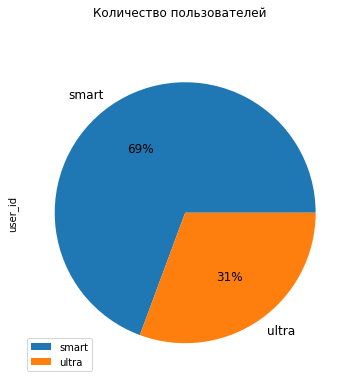

In [54]:
df.pivot_table(index='tariff', values='user_id', aggfunc = 'count')\
.plot(kind='pie', subplots = True, fontsize=12, figsize= (6,6), title = 'Количество пользователей',\
     autopct =lambda p: '{:.0f}%'.format(p))
plt.show()

Как видим на гистограмме, пользователей тарифа Smart более чем в 2 раза больше, чем пользователей тарифа Ultra.

Для удобства выделим две группы пользователей в зависимости от используемого ими тарифа.

In [55]:
df_smart = df.query('tariff == "smart"')
df_ultra = df.query('tariff == "ultra"')

### Длительность звонков в зависимости от тарифа

In [56]:
#посмотрим на описание и дисперсию по тарифу Smart
display(df_smart['call_duration'].describe())
print('Дисперсия составляет:', np.var(df_smart['call_duration']).round())

count    2229.000000
mean      393.929565
std       179.969846
min         0.000000
25%       267.000000
50%       397.000000
75%       515.000000
max      1354.000000
Name: call_duration, dtype: float64

Дисперсия составляет: 32375.0


Как видим, медиана и среднее практически одинаковы, а вот стандартное отклонение высокое, что говорит о большом разбросе данных.

In [57]:
#посмотрим на описание по тарифу Ultra
display(df_ultra['call_duration'].describe())
print('Дисперсия составляет:', np.var(df_ultra['call_duration']).round())

count     985.000000
mean      496.588832
std       299.864584
min         0.000000
25%       267.000000
50%       488.000000
75%       711.000000
max      1578.000000
Name: call_duration, dtype: float64

Дисперсия составляет: 89827.0


Все точно так же, как и на предыдущем тарифе: медиана и среднее практически одинаковы, а стандартное отклонение здесь еще выше.

Для удобства создадим функцию для вызова гистограмм, т.к. далее будем строить гистограммы для сообщений и интернет-трафика.

In [58]:
def histograms(df_smart, df_ultra, name, bins, length):
    ax = (df_smart
          .plot(kind = 'hist',
                bins = bins,
                range = length,
                alpha = 0.7,
                grid = True,
                density = True,
                legend = True,
                linewidth = 3,
                figsize=(12,6),
                label = 'smart')
         )
    (df_ultra
     .plot(kind = 'hist',
           ax = ax,
           bins = bins,
           range = length,
           alpha = 0.6,
           grid = True,
           density = True,
           legend = True,
           linewidth = 3,
           figsize=(12,6),
           label = 'ultra')
    )

    ax.set_title(name, fontsize=12)
    ax.set_xlabel(name, fontsize=12)
    ax.set_ylabel('Частота значений', fontsize=12)
    plt.show()

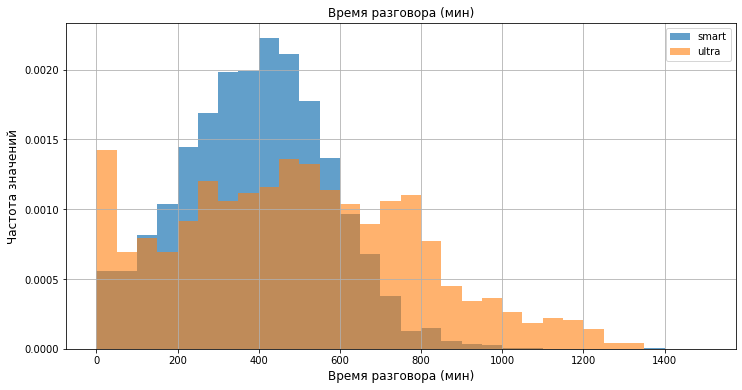

In [59]:
histograms(df_smart['call_duration'], df_ultra['call_duration'], 'Время разговора (мин)', bins = 30, length = (0, 1500))

Большинство абонентов тарифа Smart укладываются в свой лимит в 500 минут и лишь немногие платят за дополнительные минуты. Большинство проговаривает в месяц от 400 до 500 минут, что как раз укладывается в значения среднего и медианы.<br>
На гистограмме видно, что на тарифе Ultra более равномерное распределение.<br>
На тарифе Ultra абоненты разговаривают больше, но свой лимит в 3000 минут никто не использует полностью. При этом видно, что на тарифе Ultra значительно больше звонков всего до 200 минут в месяц, чем на тарифе Smart.

Посмотрим на долю абонентов, превышающих лимиты в месяц по минутам.

In [60]:
print('Превышение лимита по минутам на тарифе Smart:',
      (df_smart.query('call_duration > 500')['call_duration'].count()
      /len(df_smart)).round(2))
print('Превышение лимита по минутам на тарифе Ultra:',
      (df_ultra.query('call_duration > 3000')['call_duration'].count()
      /len(df_ultra)).round(2))

Превышение лимита по минутам на тарифе Smart: 0.28
Превышение лимита по минутам на тарифе Ultra: 0.0


34 % абонентов тарифа Smart превышают свой месячный лимит по минутам.

### Количество сообщений в зависимости от тарифа

In [61]:
#посмотрим на описание по тарифу Smart
display(df_smart['total_messages'].describe())
print('Дисперсия составляет:', np.var(df_smart['total_messages']).round())

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: total_messages, dtype: float64

Дисперсия составляет: 796.0


In [62]:
#посмотрим на описание по тарифу Ultra
display(df_ultra['total_messages'].describe())
print('Дисперсия составляет:', np.var(df_ultra['total_messages']).round())

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: total_messages, dtype: float64

Дисперсия составляет: 2283.0


На обоих тарифах среднее больше медианы. Стандартное отклонение на тарифе Ultra значительно больше, чем у тарифа Smart, что говорит о более значительном разбросе.<br>
Но в целом, исходя из описания, можно сделать вывод, что СМС уже практически не пользуются.

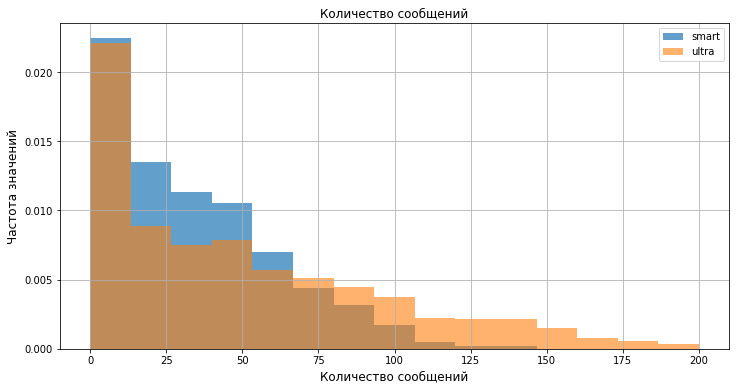

In [63]:
#построим гистограмму
histograms(df_smart['total_messages'], df_ultra['total_messages'], 'Количество сообщений', bins = 15, length = (0, 200))

Больше всего значений лежит в диапазоне от 0 до 15 значений, что, скорее всего, означает переписку с банками, да NPS-опросы. Оставшиеся абоненты используют в среднем до 75 сообщений в месяц.<br>
На тарифе Ultra пользуются СМС чаще, но при этом никто даже близко не приближается к лимиту в 1000 сообщений.<br>
А вот на тарифе Smart немалое количество пользователей превышают свой лимит в 50 СМС.

Посмотрим на количество абонентов, превышающих лимиты в месяц по сообщениям.

In [64]:
print('Превышение лимита по сообщениям на тарифе Smart:',
      (df_smart.query('total_messages > 50')['total_messages'].count()
      /len(df_smart)).round(2))
print('Превышение лимита по сообщениям на тарифе Ultra:',
      (df_ultra.query('total_messages > 1000')['total_messages'].count()
      /len(df_ultra)).round(2))

Превышение лимита по сообщениям на тарифе Smart: 0.25
Превышение лимита по сообщениям на тарифе Ultra: 0.0


На тарифе Smart превышают лимит по сообщениям 25 % абонентов, что ниже количества превышающих лимит по минутам.

### Потребление интернет-трафика в зависимости от тарифа

In [65]:
#посмотрим на описание по тарифу Smart
display(df_smart['gb_used'].describe())
print('Дисперсия составляет:', np.var(df_smart['gb_used']).round())

count    2229.000000
mean       15.828503
std         5.732887
min         0.000000
25%        12.346689
50%        16.119961
75%        19.573174
max        37.648877
Name: gb_used, dtype: float64

Дисперсия составляет: 33.0


In [66]:
#посмотрим на описание по тарифу Ultra
display(df_ultra['gb_used'].describe())
print('Дисперсия составляет:', np.var(df_ultra['gb_used']).round())

count    985.000000
mean      19.012505
std        9.850753
min        0.000000
25%       11.494395
50%       18.855479
75%       26.208682
max       48.579775
Name: gb_used, dtype: float64

Дисперсия составляет: 97.0


Как видно из описания, на тарифе Smart среднее и медиана выше, чем лимит трафика на месяц, т.е. более 50 % абонентов приобретают дополнительный трафик.<br>
На тарифе Ultra среднее и медиана находятся в пределах лимита и дополнительный трафик приобретают примерно 15 % абонентов.<br>
Среднее на обоих тарифах близко к медиане. Стандартное отклонение на тарифе Ultra почти в два раза выше, чем на Smart, что говорит о более широком разбросе данных.

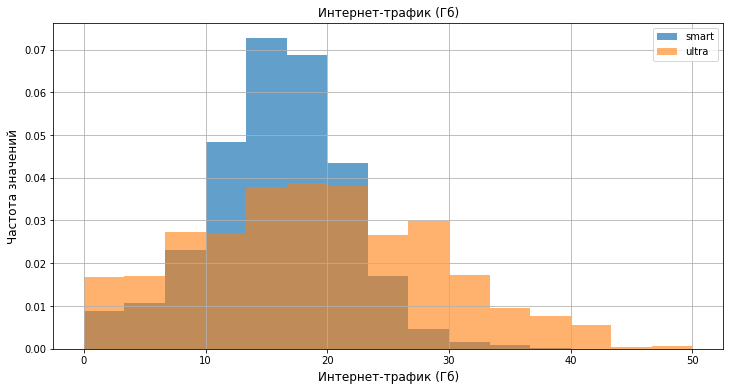

In [67]:
#построим гистограмму
histograms(df_smart['gb_used'], df_ultra['gb_used'], 'Интернет-трафик (Гб)', bins = 15, length = (0, 50))

На обоих тарифах большинство абонентов используют трафика от 13 до 20 Гб. Пользователи тарифа Ultra здесь тоже часто вылезают за пределы лимита, в отличие от минут и сообщений. Распределение данных на тарифе Ultra более равномерно.

Посмотрим на количество абонентов, превышающих лимиты по интернет-трафику.

In [68]:
print('Превышение лимита по интернет-трафику на тарифе Smart:',
      (df_smart.query('gb_used > 15')['gb_used'].count()
      /len(df_smart)).round(2))
print('Превышение лимита по интернет-трафику на тарифе Ultra:',
      (df_ultra.query('gb_used > 30')['gb_used'].count()
      /len(df_ultra)).round(2))

Превышение лимита по интернет-трафику на тарифе Smart: 0.59
Превышение лимита по интернет-трафику на тарифе Ultra: 0.14


Из этих данных можно сделать вывод, что большинству абонентов тарифа Smart не хватает интернет-трафика, входящего в тариф.

### Цена и переплата

In [69]:
#посмотрим на описание по тарифу Smart
display(df_smart['monthly_income'].describe())
print('Дисперсия составляет:', np.var(df_smart['monthly_income']).round())

count    2229.000000
mean     1197.218927
std       767.412027
min       550.000000
25%       550.000000
50%       925.582031
75%      1602.906250
max      6540.775391
Name: monthly_income, dtype: float64

Дисперсия составляет: 588657.0


In [70]:
#найдем квантиль с границей в 1950 рублей по тарифу Smart
df_smart['monthly_income'].quantile(0.8)

1798.437890625

In [71]:
#посмотрим на описание по тарифу Ultra
display(df_ultra['monthly_income'].describe())
print('Дисперсия составляет:', np.var(df_ultra['monthly_income']).round())

count     985.000000
mean     2059.868918
std       354.880790
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4736.966309
Name: monthly_income, dtype: float64

Дисперсия составляет: 125813.0


По тарифу Smart очень интересная ситуация: значительная часть пользователей платит за тариф намного больше, чем составляет ежемесячная плата в 550 рублей. Среднее находится на уровне 1294 руб., а медиана на уровне 1038 рублей. 20 % абонентов тарифа Smart могут переходить на тариф Ultra, т.к. они платят столько же или даже больше. Это стало понятно потому, что на 80-м квантиле ежемесячная оплата пользователей тарифа Smart составляет 1950 рублей.<br>
На тарифе Ultra ситуация противоположная - большинство абонентов расходует пакеты в пределах тарифа.

Построим гистограмму с соотношением выручки между тарифами.

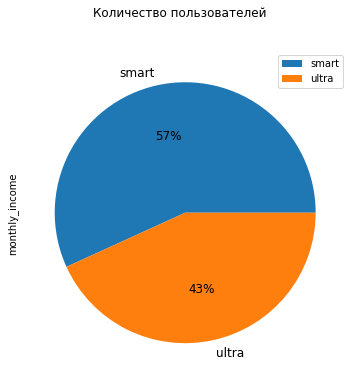

In [72]:
df.pivot_table(index='tariff', values='monthly_income', aggfunc = 'sum')\
.plot(kind='pie', subplots = True, fontsize=12, figsize= (6,6), title = 'Количество пользователей',\
     autopct =lambda p: '{:.0f}%'.format(p))
plt.show()

Пользователи Smart принесли выручки на 18 % больше, чем пользователи Ultra, но при этом их количество в 2 раза больше, то есть тариф Smart получается для пользователей дешевле.

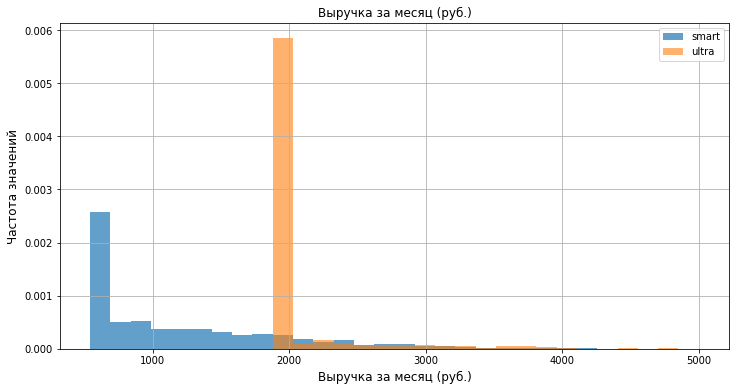

In [73]:
#построим гистограмму
histograms(df_smart['monthly_income'], df_ultra['monthly_income'], 'Выручка за месяц (руб.)', bins = 30, length = (540, 5000))

In [74]:
print('Переплата сверх абонентской платы на тарифе Smart:',
      (df_smart.query('monthly_income > 550')['monthly_income'].count()
      /len(df_smart)).round(2))
print('Переплата сверх абонентской платы на тарифе Ultra:',
      (df_ultra.query('monthly_income > 1950')['monthly_income'].count()
      /len(df_ultra)).round(2))

Переплата сверх абонентской платы на тарифе Smart: 0.73
Переплата сверх абонентской платы на тарифе Ultra: 0.14


На гистограмме видно всё то же самое, что и было в описании - 75 % пользователи тарифа Smart очень часто переплачивают сверх ежемесячной платы, в отличие от тарифа Ultra, на котором подавляющее большинство пользователей укладываются в лимиты по пакетам и абонентскую плату.

### Вывод по разделу

<font size = 3><b>Исходя из анализа данных можно сделать следующие выводы:</b></font>
1. Количество пользователей на тарифе Smart превышает количество пользователей тарифом Ultra более чем в 2 раза.
2. По количеству минут и сообщений на тарифе Smart большинство пользователей укладывается в лимиты тарифы, а вот дополнительный интернет-трафик приобретают 59 % пользователей.
3. Пользователи тарифа Ultra не используют весь пакет минут и сообщений и всего 14 % пользователей не укладываются в лимит по интернет-трафику.
4. Переплачивают сверх абонентской платы на тарифе Smart аж 75 % пользователей, в то время как всего 14 пользователей тарифа Ultra платят сверх абонентской платы (как раз 14 % пользователей, превышающих лимит по интернет-трафику).
5. Примерно 20 % абонентов тарифа Smart могут безболезненно для себя перейти на тариф Ultra, т.к. они платят в месяц 1950 рублей и более.
6. Уже сейчас можно сказать, что для оператора выгоднее тариф Ultra, т.к. его пользователи в среднем в месяц платят 2071 руб., а пользователи тарифа Smart платят в месяц в среднем 1294 руб. При этом пользователи тарифа Ultra не используют все пакеты связи, которые им предоставляет оператор, что также приносит дополнительную выгоду мобильному оператору.
<br>
<br>

## Проверка гипотез

В этом разделе мы проверим 2 гипотезы:
1. Что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Гипотеза 1: средняя выручка от пользователей тарифов «Ультра» и «Смарт» различается

Сравним среднюю выручку в тарифах Smart и Ultra. Сформулируем нулевую и альтернативную гипотезы.<br>
<b>Нулевая гипотеза(Н0):</b> средняя выручка по тарифам Smart и Ultra не различается.<br>
    <b>Альтернативная гипотеза(Н1):</b> средняя выручка по тарифам Smart и Ultra различается. Альтернативная гипотеза двухсторонняя - нам не важно в какую сторону будет отклонение, важен сам факт наличия отклонения, т.е. то, что средняя выручка по тарифам не равна.

Проверим гипотезу о равенстве средних значений выручки.

In [75]:
print('Средняя выручка по тарифу Smart:', df_smart['monthly_income'].mean())
print('Средняя выручка по тарифу Ultra:', df_ultra['monthly_income'].mean())

Средняя выручка по тарифу Smart: 1197.218926999215
Средняя выручка по тарифу Ultra: 2059.8689175523477


Как видим, разница в средней выручке составляет аж более 30 %, поэтому указываем параметр `equal_var=False`.

Установим уровень значимости (alpha) равным 0,05.
Т.к. проверяем гипотезу о равенстве среднего двух совокупностей по выборкам, применим метод scipy.stats.ttest_ind

In [76]:
smart_mean = df_smart['monthly_income']
ultra_mean = df_ultra['monthly_income']

alpha = 0.05 
results = st.ttest_ind(
    smart_mean,
    ultra_mean,
    equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута, значит принимаем за истину альтернативную гипотезу, что средняя выручка по тарифа Smart и Ultra различается.

<b>Итак, наша основная гипотеза подтверждается и средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.</b>

### Гипотеза 2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

<b>Нулевая гипотеза(Н0):</b> средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.<br>
<b>Альтернативная гипотеза(Н1):</b> средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [77]:
#отфильтруем датасет по городам
moscow = df.query('city == "Москва"')
others = df.query('city != "Москва"')

In [78]:
#посмотрим на средние значения этих выборок
print ('Среднее значения по Москве:', moscow['monthly_income'].mean())
print ('Среднее значения по другим городам:', others['monthly_income'].mean())

Среднее значения по Москве: 1484.8365688292758
Среднее значения по другим городам: 1456.1416552115347


Разница между двумя средними значениями составляет всего 1,5 %, значит используем параметр `equal_var=True`

Установим уровень значимости (alpha) равным 0,05.
Т.к. проверяем гипотезу о равенстве среднего двух совокупностей по выборкам, применим метод scipy.stats.ttest_ind

In [79]:
moscow_mean = moscow['monthly_income']
others_mean = others['monthly_income']

alpha = 0.05 
results = st.ttest_ind(
    moscow_mean,
    others_mean,
    equal_var=True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4119903138820259
Не получилось отвергнуть нулевую гипотезу


Как видим, нулевую гипотезу отвергнуть не получилось и выручка от пользователей из Москвы не отличается от выручки пользователей из других городов.

<b>Наша основная гипотеза отвергнута и средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.</b>

### Вывод по разделу

На основании статистического анализа мы пришли к следующим выводам:
1. Гипотеза 1 подтвердилась и средняя <b>выручка от пользователей тарифов «Ультра» и «Смарт» различается.</b>
2. Гипотеза 2 опровергнута и средняя <b>выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.</b>

## Общий вывод

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Нам предстояло сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно было проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
1. <b>Были представлены и изучены 5 датасетов:</b> со звонками, сообщениями, интернет-трафиком, тарифами и пользователями.
2. <b>Была проведена предобработка этих датасетов:</b>
    - привели данные в столбцах с датой к типу datetime;
    - добавили столбцы с месяцем к датасетам со звонками, сообщениями и интернет-сессиями;
    - округлили данные в большую сторону в столбцах с минутами и интернет-трафиком;
    - перевели Мб в Гб;
    - сгруппировали данные и объединили их в новый датасет;
    - удалили из нового датасета столбцы, которые не будут использоваться при дальнейшем анализе;
3. <b>Подготовили данные для анализа:</b>
    - посчитали в сводной таблице по месяцам:
        1. количество сделанных звонков и израсходованных минут разговора;
        2. количество отправленных сообщений;
        3. объем израсходованного интернет-трафика;
    - посчитали помесячную выручку с каждого пользователя.
4. <b>При исследовательском анализе данных были сделаны следующие выводы:</b>
    1. Количество пользователей на тарифе Smart превышает количество пользователей тарифом Ultra более чем в 2 раза.
    2. По количеству минут и сообщений на тарифе Smart большинство пользователей укладывается в лимиты тарифы, а вот дополнительный интернет-трафик приобретают 59 % пользователей.
    3. Пользователи тарифа Ultra не используют весь пакет минут и сообщений и всего 14 % пользователей не укладываются в лимит по интернет-трафику.
    4. Переплачивают сверх абонентской платы на тарифе Smart аж 75 % пользователей, в то время как всего 14 пользователей тарфиа Ultra платят сверх абонентской платы (как раз 14 % пользователей, превышающих лимит по интернет-трафику).
    5. Примерно 20 % абонентов тарифа Smart могут безболезненно для себя перейти на тариф Ultra, т.к. они платят в месяц 1950 рублей и более.
    6. Уже сейчас можно сказать, что для оператора выгоднее тариф Ultra, т.к. его пользователи в среднем в месяц платят 2071 руб., а пользователи тарифа Smart платят в месяц в среднем 1294 руб. При этом пользователи тарифа Ultra не используют все пакеты связи, которые им предоставляет оператор, что также приносит дополнительную выгоду мобильному оператору.
5. <b>На основании статистического анализа данных мы пришли к следующим выводам:</b>
    1. Гипотеза 1 подтвердилась и средняя выручка от пользователей тарифов «Ультра» и «Смарт» различается. Пользователи тарифа Ультра платят ежемесячно на 38 % больше, чем пользователи тарифа Smart.
    2. Гипотеза 2 опровергнута и средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.